# E-Commerce Customer Segmentation

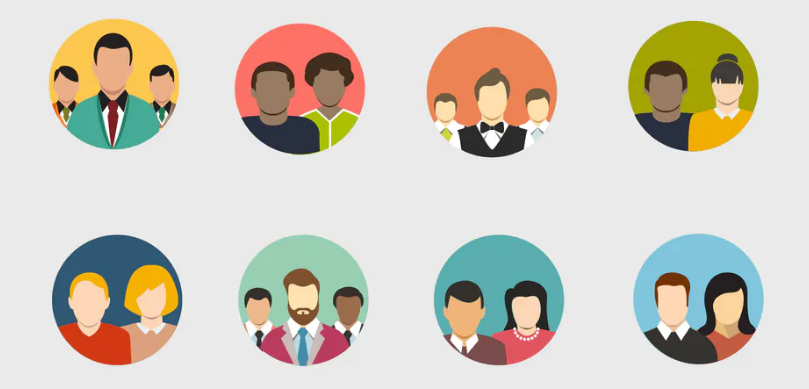

Customer segmentation is an effective tool for businesses to closely align their strategy and tactics with, and better target, their customers. Every customer is different and every customer journey is different so a single approach often isn’t going to work for all. This is where customer segmentation becomes a valuable process.

> Customer segmentation is the process by which you divide your customers into segments up based on common characteristics – such as demographics or behaviors, so you can market to those customers more effectively.

Customer segmentation can be broken down into two types: 
- Segmenting customers based on who they are: the process of understanding who customers are typically focuses on demographics.
- Segmenting customers based on what they do: you can also segment customers based on how much they spend (share of wallet), how often, and what products (this allows you to see how much you can increase spend). This is more behavior focused. **That's the data we have and the kind of segmentation we will do.**


### Research questions
The aim of the study is to answer the below research questions:
- What is the general sales trend?
- What is an average cart by country?
- What countries are the most active?
- What are the best selling products?
- How often do customers buy products?
- How many new customers each months?
- When do customers tend to purchase products?


### About the dataset

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Features

1. *InvoiceNo*: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
2. *StockCode*: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
3. *Description*: Product (item) name. Nominal. 
4. *Quantity*: The quantities of each product (item) per transaction. Numeric. 
5. *InvoiceDate*: Invice Date and time. Numeric, the day and time when each transaction was generated. 
6. *UnitPrice*: Unit price. Numeric, Product price per unit in sterling. 
7. *CustomerID*: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
8. *Country*: Country name. Nominal, the name of the country where each customer resides.

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

sns.set_style("whitegrid")

Install: seaborn, sklearn

---

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("data/data.csv",encoding = 'unicode_escape')
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head()

There are 541909 observations for 8 predictors.


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df["Quantity"] = abs(df["Quantity"])
df["UnitPrice"] = abs(df["UnitPrice"])
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["InvoiceDate"].dt.year!=2011)|(df["InvoiceDate"].dt.month!=12)]

---

### What is the general sales trend?

To understand the general sales trend, I will plot the amount of money generated by the sales for each day through the studied period.

In [5]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)

In [6]:
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,12)]

In [7]:
rolling_days = general_trend.copy()
rolling_days["Total price"] = rolling_days["Total price"].rolling(window=30).mean() 

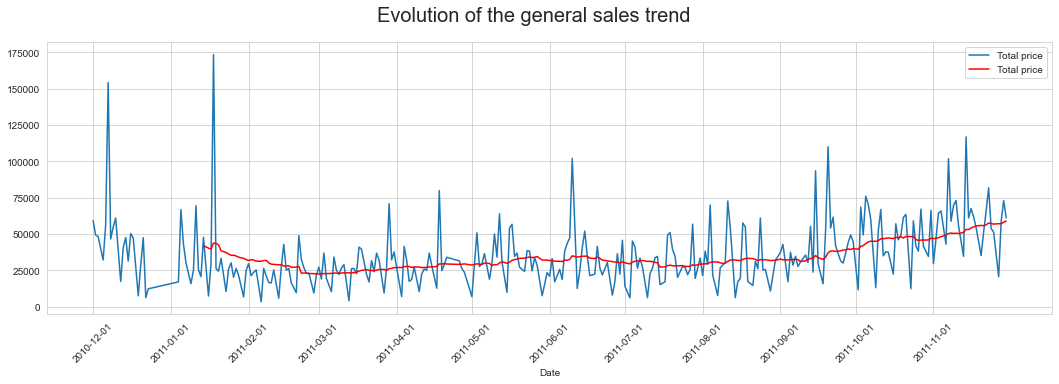

In [8]:
plt.figure(figsize = (18,5)).suptitle('Evolution of the general sales trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

In [9]:
general_trend.index = pd.to_datetime(general_trend.index)
general_trend_months = general_trend.groupby([general_trend.index.year,general_trend.index.month])['Total price'].sum()
general_trend_months = pd.DataFrame(general_trend_months)

In [10]:
general_trend_months

Total price
Date Date             
2010 12     898535.260
2011 1      822728.860
     2      549201.130
     3      752011.640
     4      582410.121
     5      817738.530
     6      832356.680
     7      757142.271
     8      835596.250
     9     1097492.722
     10    1239253.930
     11    1557236.410

In [11]:
general_trend_months["Date"] = dates

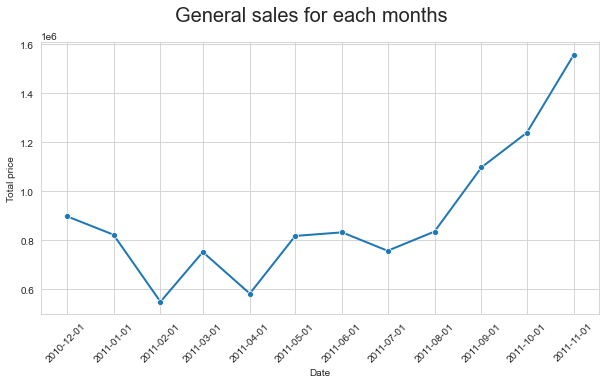

In [12]:
plt.figure(figsize = (10,5)).suptitle('General sales for each months', fontsize=20)
sns.lineplot(data=general_trend_months,x="Date", y="Total price", marker="o",linewidth = 2)

plt.xticks(dates,rotation = 45)

plt.show()

> 📌 From this curve giving the sales trend between december 2010 and december 2011, it seems that the general sales was quite stable untill august 2011. The general sales increases drastically and are almost multiplied by 3. This increase may also be linked to end of the year celebrations, where people tend to buy more products.

---

### What is an average cart by country?

In this part I will study the trends per countries to spot any differencies.
First of all try to see if there are difference in the way customers frome each country buy products in term of quantities and prices.

In [13]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

In [14]:
average_cart_countries = df.groupby("Country").TotalPrice.mean()
average_cart_countries = pd.DataFrame(average_cart_countries).reset_index()

average_price_countries = df.groupby("Country").UnitPrice.mean()
average_price_countries = pd.DataFrame(average_price_countries).reset_index()

average_quantity_countries = df.groupby("Country").Quantity.mean()
average_quantity_countries = pd.DataFrame(average_quantity_countries).reset_index()

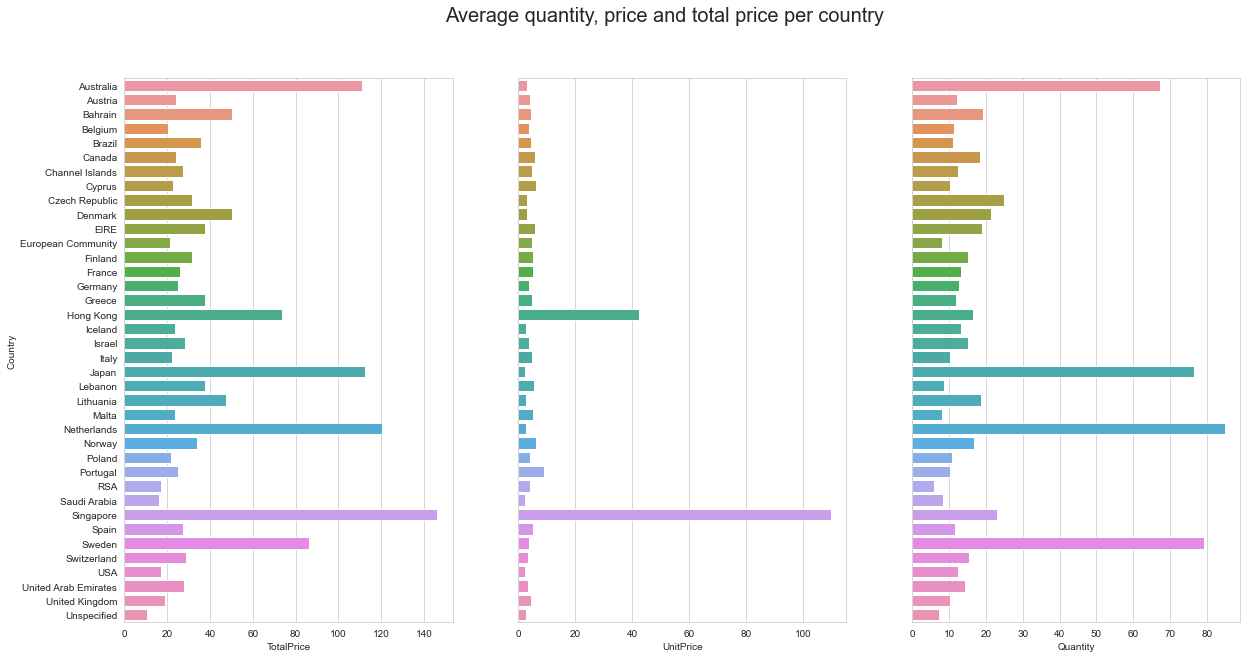

In [15]:
fig = plt.figure(figsize = (20,10))
fig.suptitle("Average quantity, price and total price per country",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=average_cart_countries,x="TotalPrice",y="Country")

axes = fig.add_subplot(1, 3, 2)
sns.barplot(data=average_price_countries,x="UnitPrice",y="Country")
fig.axes[1].get_yaxis().set_visible(False)

axes = fig.add_subplot(1, 3, 3)
sns.barplot(data=average_quantity_countries,x="Quantity",y="Country")
fig.axes[2].get_yaxis().set_visible(False)

In [16]:
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = average_cart_countries["Country"],
                  locationmode = "country names",
                  z = average_cart_countries["TotalPrice"].astype(float).round(0).tolist(),
                  hovertext = average_cart_countries["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Total Price", },
                ) 



layout = dict(
              title = "Average Total Price Per Cart By Country",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
# fig.update_traces(visible = True)
iplot(fig)

>📌 There are four countries that tend to buy have an average cart bigger than the others: the Netherlands, Australia, Japan and Sweden. Based on the plots for quantity and total prices, it seems that those countries have a bigger carts because of quantities, a customer from those countries will buy more quantities than in others.
>
> Hong Kong and Singapore customers tend to be more attracted by expensive items.

---
### What are the best selling products?

We can also exhibit what products are the most bought.

In [17]:
most_frequent_per_country = df.groupby("Country").Description.agg(pd.Series.mode)
most_frequent_per_country

Country
Australia                               SET OF 3 CAKE TINS PANTRY DESIGN 
Austria                                                           POSTAGE
Bahrain                                OCEAN SCENT CANDLE IN JEWELLED BOX
Belgium                                                           POSTAGE
Brazil                  [CLOCK MAGNET MUM'S KITCHEN, COOK WITH WINE ME...
Canada                                       COLOURING PENCILS BROWN TUBE
Channel Islands         [DOORMAT HOME SWEET HOME BLUE , LUNCH BAG RED ...
Cyprus                                           REGENCY CAKESTAND 3 TIER
Czech Republic          [JIGSAW TREE WITH BIRDHOUSE, PINK METAL CHICKE...
Denmark                                                           POSTAGE
EIRE                                                             CARRIAGE
European Community                                                POSTAGE
Finland                                                           POSTAGE
France                        

In [18]:
df.Description.value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    2306
REGENCY CAKESTAND 3 TIER              2134
JUMBO BAG RED RETROSPOT               2101
PARTY BUNTING                         1699
LUNCH BAG RED RETROSPOT               1594
ASSORTED COLOUR BIRD ORNAMENT         1454
SET OF 3 CAKE TINS PANTRY DESIGN      1426
PACK OF 72 RETROSPOT CAKE CASES       1348
LUNCH BAG  BLACK SKULL.               1298
NATURAL SLATE HEART CHALKBOARD        1235
Name: Description, dtype: int64

> 📌 The best selling product is the "white hanging heart T-light holder". The best selling items are different based on the countries.

---

### How often do customers buy products?

In this part, I will study how often customers from the different countries buy items on the website.

In [19]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df_temp = df[(df["InvoiceDate"].dt.year!=2011)|(df["InvoiceDate"].dt.month!=12)]

In [20]:
count_transactions_per_country = df_temp.groupby([df_temp.Country,df.InvoiceDate]).Description.count().reset_index()
count_transactions_per_country = count_transactions_per_country.groupby([count_transactions_per_country.Country]).Description.sum()
count_transactions_per_country = pd.DataFrame(count_transactions_per_country)

In [21]:
unique_per_country = df_temp.groupby([df_temp.Country]).CustomerID.nunique()
unique_per_country = pd.DataFrame(unique_per_country)
unique_per_country = unique_per_country.drop("Hong Kong")

In [22]:
transactions_per_customer_per_countries = pd.concat([count_transactions_per_country,unique_per_country],axis=1).reset_index()
transactions_per_customer_per_countries["Value"] = transactions_per_customer_per_countries["Description"]/transactions_per_customer_per_countries["CustomerID"]/12

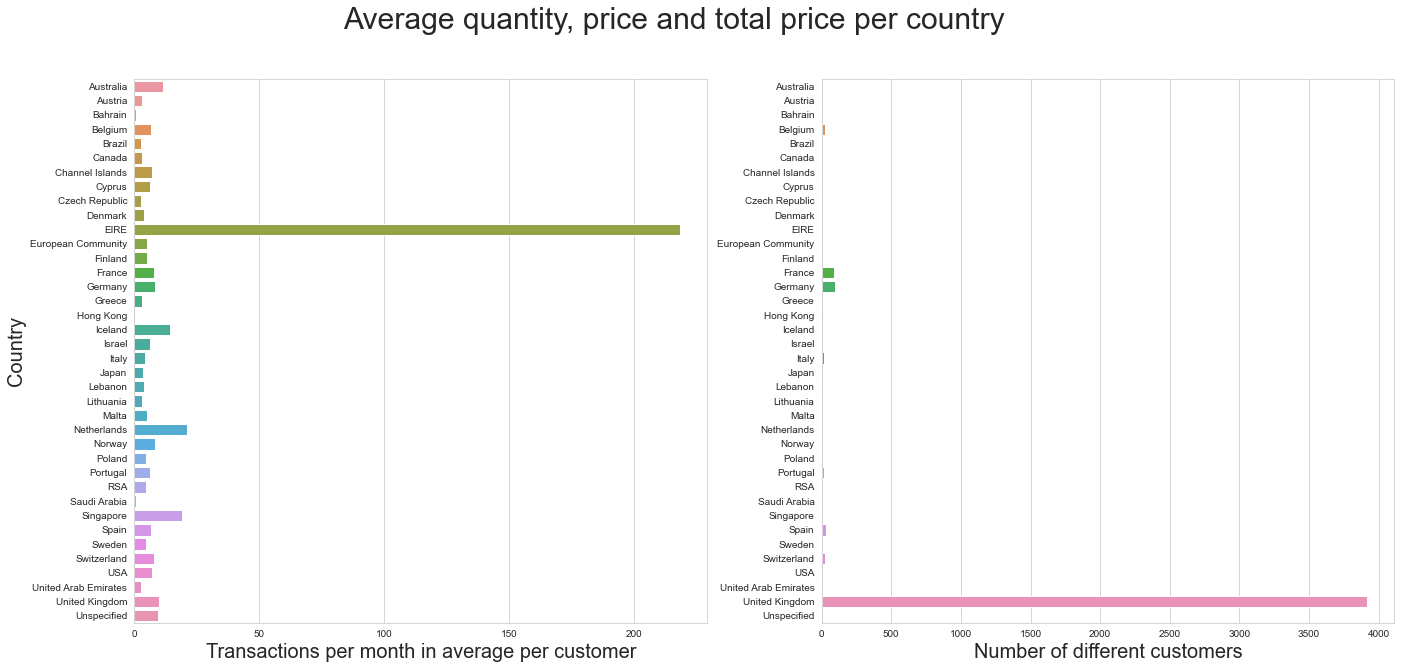

In [23]:
fig = plt.figure(figsize = (20,10))
fig.suptitle("Average quantity, price and total price per country",size=30)

axes = fig.add_subplot(1, 2, 1)
sns.barplot(data=transactions_per_customer_per_countries,x="Value",y="Country")
axes.set_xlabel('Transactions per month in average per customer',size = 20)
axes.set_ylabel('Country',size = 20)

axes = fig.add_subplot(1, 2, 2)
sns.barplot(data=transactions_per_customer_per_countries,x="CustomerID",y="Country")
axes.set_xlabel('Number of different customers',size = 20)
axes.set_ylabel('')

plt.subplots_adjust(right=1)

plt.show()

We can calculate the global average for the number of transaction per month per customers:

In [24]:
transactions_per_customer_per_countries.Description.sum()/transactions_per_customer_per_countries.CustomerID.sum()/12

9.889855573480833

> 📌 This graph highlights that in average, customers will customers will make around 10 transactions per month. There is one big exception with Ireland, where there is an average of 225 transaction but this is linked to only three customers.
>
> It is also visible that most of the customers comes from UK with almost 4,000 unique customers, then France and Germany far behind with around 100.

---

### What countries are the most active?

In [25]:
general_trend_country = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate),
                                   'Country':df.Country,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend_country = general_trend_country.groupby([general_trend_country.Date.dt.to_period("M"),general_trend_country.Country]).sum()
general_trend_country = pd.DataFrame(general_trend_country).reset_index()


In [26]:
general_trend_country.groupby([general_trend_country.Country]).sum().sort_values(by='Total price',ascending=False).head(10)

Total price
Country                    
United Kingdom  9066129.054
EIRE             296272.360
Netherlands      274503.120
Germany          227872.430
France           214521.310
Australia        139965.350
Spain             68018.650
Switzerland       57794.450
Belgium           40055.690
Sweden            39684.750

In [27]:
general_trend_country.Date = general_trend_country.Date.dt.to_timestamp()

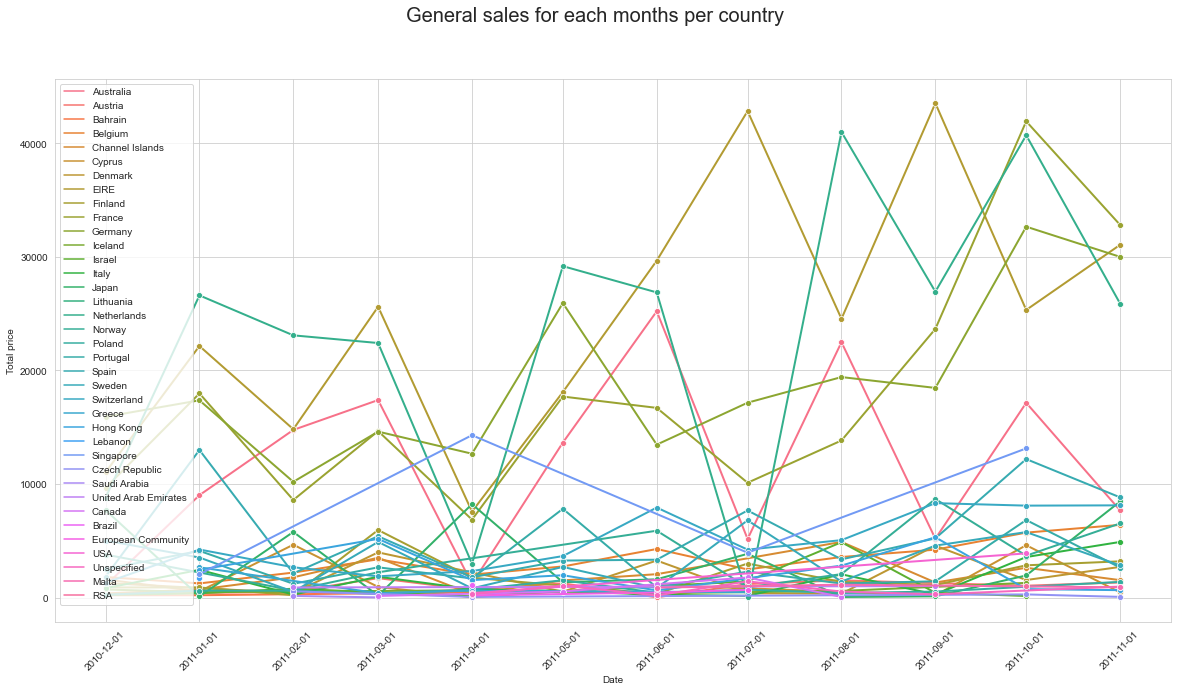

In [28]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months per country', fontsize=20)
sns.lineplot(data=general_trend_country.loc[general_trend_country.Country!="United Kingdom"],x="Date", y="Total price",hue="Country", marker="o",linewidth = 2)

x_dates = pd.to_datetime(dates).strftime('%Y-%m').sort_values().unique()

plt.xticks(x_dates,rotation = 45)
plt.legend(loc='upper left')

plt.show()

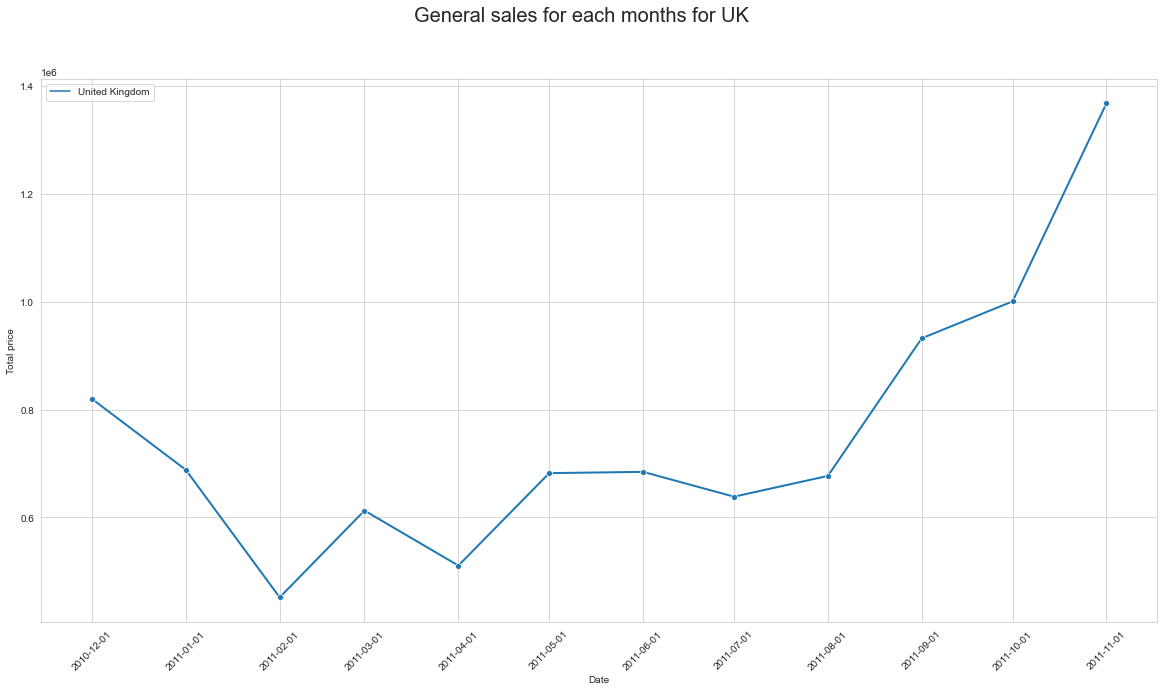

In [29]:
fig  = plt.figure(figsize = (20,10)).suptitle('General sales for each months for UK', fontsize=20)
sns.lineplot(data=general_trend_country.loc[general_trend_country.Country=="United Kingdom"],x="Date", y="Total price",hue="Country", marker="o",linewidth = 2)

x_dates = pd.to_datetime(dates).strftime('%Y-%m').sort_values().unique()

plt.xticks(x_dates,rotation = 45)
plt.legend(loc='upper left')

plt.show()

> 📌 Obviously, since the E-Commerce website is from UK, as expected the biggest market is there. Other countries seem to be quite interesting markets too especially in Europe such as the Netherlands, Ireland, Germany France and also Australia.
> Thus it may be interesting to try to develop those countries since for the moment the main customers origin is UK.
>
> As we can see on the curve, the increase in august 2011 is mainly due to United Kingdom market.

---

### How many new customers each months?

In [30]:
number_new_customers = []
customers_seen = []
for month in df_temp["InvoiceDate"].dt.to_period('M').unique():
    customers = df_temp[df_temp["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count=0
    for customer in customers:
        if customer not in customers_seen:
            count+=1
            customers_seen.append(customer)
    number_new_customers.append((month,count))
number_new_customers = pd.DataFrame(number_new_customers,columns=["Date","New customers"])
number_new_customers.Date = number_new_customers.Date.dt.to_timestamp()

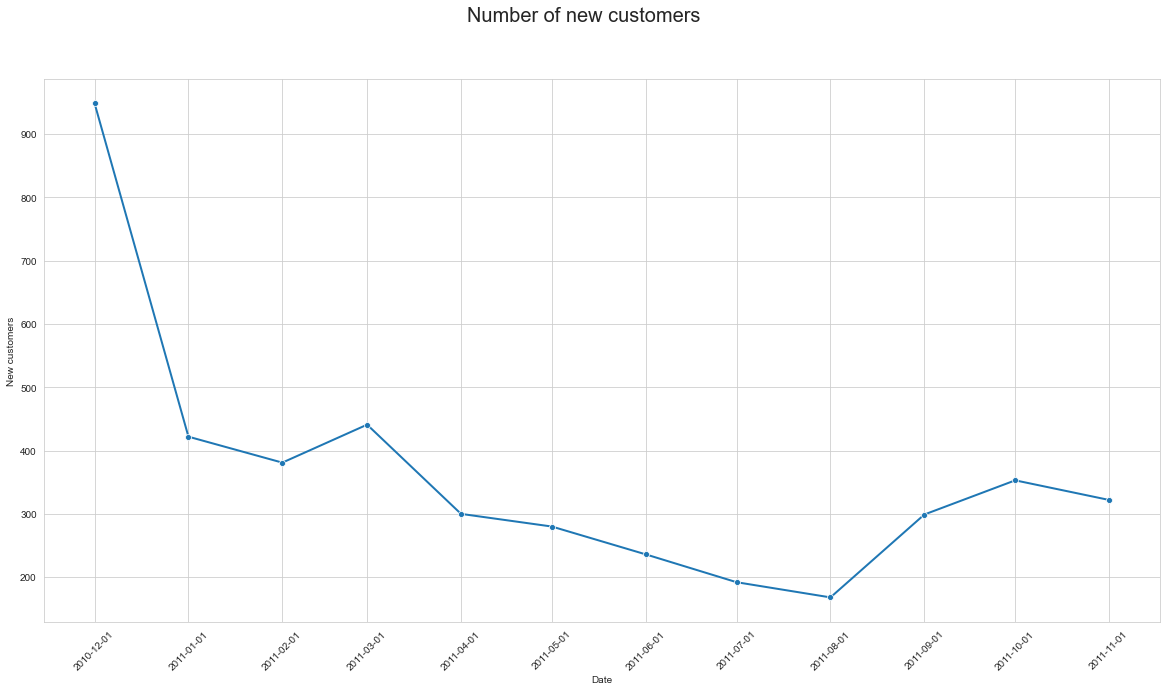

In [31]:
fig  = plt.figure(figsize = (20,10)).suptitle('Number of new customers', fontsize=20)
sns.lineplot(data=number_new_customers,x="Date", y="New customers", marker="o",linewidth = 2)

plt.xticks(dates,rotation = 45)

plt.show()

> 📌 The number of new customers keeps decreasing probably due to the fact that we don't have enough historical data and some customers were already here before.
>
> However there is a real increase in customer acquisition on august 2011 probably due to a marketing campain targeting prospects. This probably explains the rise in the genral sales trend studied above.

---

### When do customers tend to purchase products?

In this part, I will try to understand if customers tend to purchase items in more particular time of the day.

In [32]:
df_temp = df.groupby([df.CustomerID,df.InvoiceDate]).Quantity.sum()
df_temp = pd.DataFrame(df_temp).reset_index()

In [33]:
df_temp["Hour"]= df_temp["InvoiceDate"].dt.hour
df_temp["Month"]= df_temp["InvoiceDate"].dt.to_period('M')

In [34]:
count_hours = pd.DataFrame(columns=range(1,25))
count_hours["Month"] = ""

for month in sorted(df_temp["Month"].unique()):
    row = []
    for hour in range(1,25):
        freq = len(df_temp[(df_temp["Month"]==month)&(df_temp["Hour"]==hour)])
        row.append(freq)
    row.append(month)
    count_hours.loc[len(count_hours)] = row
    
count_hours = count_hours.fillna(0)       
count_hours = count_hours.set_index("Month")    

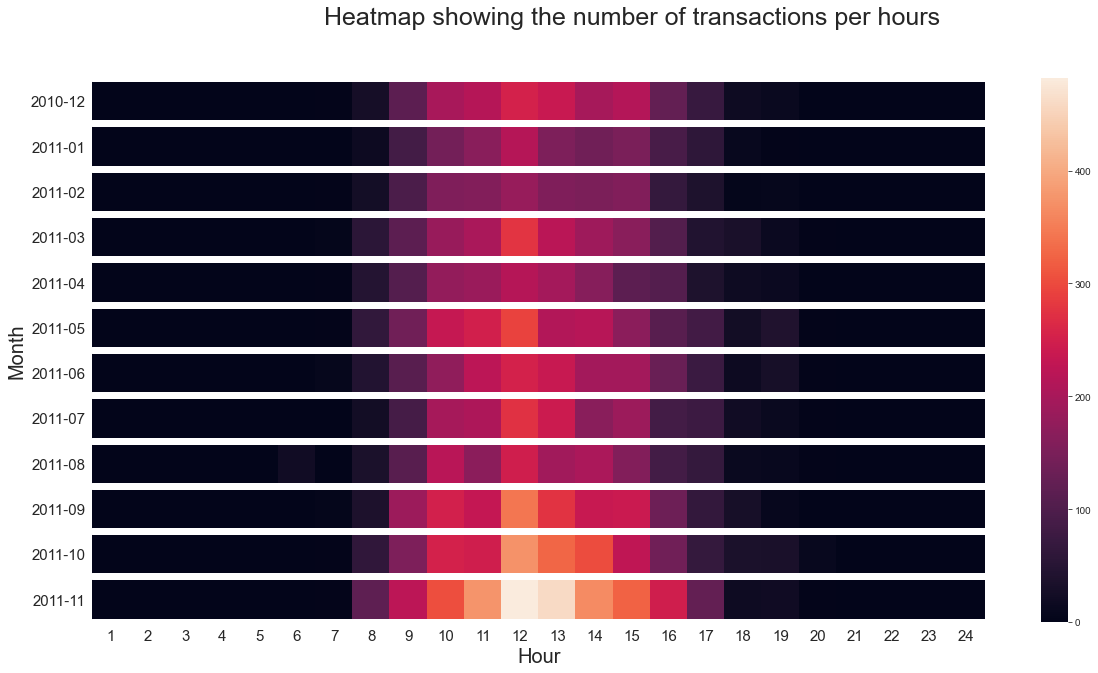

In [35]:
fig  = plt.figure(figsize = (20,10)).suptitle('Heatmap showing the number of transactions per hours', fontsize=25)
heatmap = sns.heatmap(data=count_hours)
plt.yticks(rotation=0,size=15)
plt.xticks(size=15)
heatmap.set_xlabel("Hour",fontsize=20)
heatmap.set_ylabel("Month",fontsize=20)
for i in range(count_hours.shape[1] + 1):
    plt.axhline(i, color='white', lw=7)

plt.show()

To describe the parts of the day, I used as a reference the [Britannica Dictionary](https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc).

In [36]:
def daytime_encoder(date):
    if (date.hour >= 5)&(date.hour < 8):
        return "Early morning"
    elif (date.hour >= 8)&(date.hour < 11):
        return "Morning"
    elif (date.hour >= 11)&(date.hour < 12):
        return "Late morning"
    elif (date.hour >= 13)&(date.hour < 14):
        return "Early afternoon"
    elif (date.hour >= 14)&(date.hour < 15):
        return "Afternoon"
    elif (date.hour >= 15)&(date.hour < 17):
        return "Late afternoon"
    elif (date.hour >= 17)&(date.hour < 21):
        return "Evening"
    else:
        return "Night"

df_temp['InvoiceDate'] = df_temp['InvoiceDate'].map(daytime_encoder)

<AxesSubplot:xlabel='InvoiceDate', ylabel='count'>

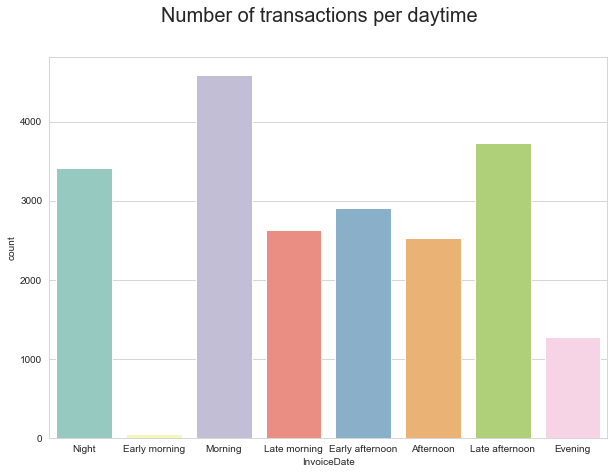

In [37]:
fig  = plt.figure(figsize = (10,7)).suptitle('Number of transactions per daytime', fontsize=20)
sns.countplot(data=df_temp,x="InvoiceDate",order = ["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"], palette="Set3")

>  📌 It seems that most of the transaction are made in the morning between 11am and 12am and late afternoon between 5pm and 21pm. 
>On early morning though between 5am and 8am, there are not a lot of transactions made.

---

## Segmentation of the customers